In [127]:
#import midi_functions
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras import optimizers

from IPython.display import clear_output
import matplotlib.pyplot as plt

#import pydot as pyd
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

In [136]:
input_length = 10
X_orig = np.loadtxt('10HX.txt')
Y_orig = np.loadtxt('10HY.txt')

permutation = np.random.permutation(len(X_orig))
X_orig = X_orig[permutation]
Y_orig = Y_orig[permutation]

print('Shortened data set')
X = np.copy(X_orig[:10000])
Y = np.copy(Y_orig[:10000])

sorted_notes = np.unique(Y)

n_notes_X_orig = len(np.unique(X_orig))
n_notes_Y_orig = len(np.unique(Y_orig))
n_notes_X = len(np.unique(X))
n_notes_Y = n_hidden_units = len(sorted_notes)
max_note = np.max(Y)
min_note = np.min(Y)

X_unnormalized = np.copy(X)
X = X / max_note #normalize input
for i,note in enumerate(Y): #make all the notes a number between 0 and number_of_different_notes
    Y[i] = np.where(sorted_notes == note)[0]
Y = np_utils.to_categorical(Y)

#Add noise to output. Equal probability of center one up and down
#The range which we care about
Y_old = np.copy(Y)
for index, y in enumerate(Y):
    hot = np.argmax(y)
    if (hot < 100 and hot > 40):
        Y[index,hot] = 0
        hot = hot + np.random.randint(-1,2)
        Y[index,hot] = 1

print('Make sure these numbers are the same: X_orig={}, Y_orig={}, X={}, Y={}'.format(n_notes_X_orig, n_notes_Y_orig, n_notes_X, n_notes_Y))
print('Number of different notes (hidden units): {}'.format(n_notes_Y))
print('Shape of X: {}'.format(X.shape))
print('Max: {}, Min: {}'.format(int(max_note), int(min_note)))
n = X.shape[0]

Shortened data set
Make sure these numbers are the same: X_orig=85, Y_orig=85, X=80, Y=77
Number of different notes (hidden units): 77
Shape of X: (10000, 10)
Max: 106, Min: 26


In [144]:
Y_old[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [145]:
Y[3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [146]:
#Run this if you want to save the shortened data set
np.savetxt('shortened-HX.txt',X_unnormalized,fmt='%i')
np.savetxt('shortened-HY.txt',Y,fmt='%i')
np.savetxt('shortened-sorted_Hnotes.txt',sorted_notes,fmt='%i')

In [147]:
#Run this if you want to laod shortened data set
X = np.loadtxt('shortened-HX.txt')
Y = np.loadtxt('shortened-HY.txt')
sorted_notes = np.loadtxt('shortened-sorted_Hnotes.txt')
n_notes_X = len(np.unique(X))
n_notes_Y = n_hidden_units = len(sorted_notes)

X_unnormalized = np.copy(X)
X = X / max_note #normalize input

print('Make sure these numbers are the same: X={}, Y={}'.format(n_notes_X, n_notes_Y))
print('Number of different notes (hidden units): {}'.format(n_notes_Y))
print('Shape of X: {}'.format(X.shape))
print('Max: {}, Min: {}'.format(int(max_note), int(min_note)))

Make sure these numbers are the same: X=80, Y=77
Number of different notes (hidden units): 77
Shape of X: (10000, 10)
Max: 106, Min: 26


Text(0.5, 1.0, 'Full dataset with 318999 examples')

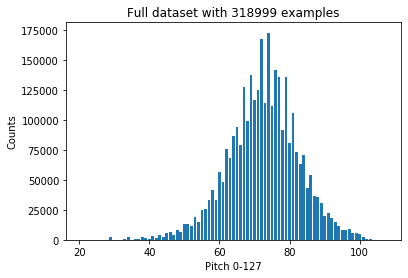

In [85]:
#Plots of note distribution
def prep_bar_plot(W):
    s = np.unique(W)
    counts = np.zeros(len(s))
    for i, note in enumerate(s):
        counts[i] = np.sum(W == note)
    return (s,counts)

s_notes, counts = prep_bar_plot(X_orig)
plt.bar(s_notes, counts)
plt.ylabel('Counts')
plt.xlabel('Pitch 0-127')
plt.title('Full dataset with {} examples'.format(len(X_orig)))

Text(0.5, 1.0, 'Reduced dataset with 10000 examples')

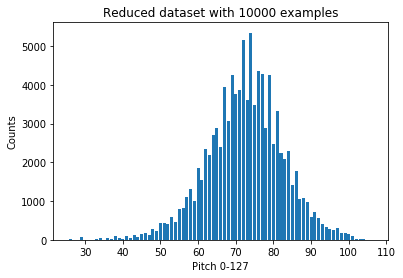

In [86]:
s_notes, counts = prep_bar_plot(X_unnormalized)
plt.bar(s_notes, counts)
plt.ylabel('Counts')
plt.xlabel('Pitch 0-127')
plt.title('Reduced dataset with {} examples'.format(len(X_unnormalized)))

In [148]:
model = Sequential()
model.add(LSTM(
    256,
    input_shape=((input_length,1)),
    return_sequences=True
))
model.add(LSTM(n_hidden_units, return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(n_hidden_units))
model.add(Activation('softmax'))
rmsprop = optimizers.RMSprop(lr=0.002, rho=0.9, epsilon=None, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
# Load the weights to each node
#model.load_weights('./hijacked_weights/10LSTM256-LSTM-400-0.2227.hdf5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 10, 256)           264192    
_________________________________________________________________
lstm_12 (LSTM)               (None, 77)                102872    
_________________________________________________________________
dense_6 (Dense)              (None, 77)                6006      
_________________________________________________________________
activation_6 (Activation)    (None, 77)                0         
Total params: 373,070
Trainable params: 373,070
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
#Remember to change the name of the log file
class live_plot(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.index = 0
        self.epochs = []
        
        self.losses = []
        self.val_losses = []
        
        self.acc = []
        self.val_acc = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.epochs.append(self.index)
        
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs['val_acc'])
        self.index += 1
        
        clear_output(wait=True)
        plt.plot(self.epochs, self.losses, label="loss")
        plt.plot(self.epochs, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
        plt.plot(self.epochs, self.acc, label="acc")
        plt.plot(self.epochs, self.val_acc, label="val_acc")
        plt.legend()
        plt.show();
        
class dump_to_file(callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        with open('hijacked_training_log.txt','wb') as f:
            np.savetxt(f,np.array([logs.get('loss'),logs.get('val_loss'),logs.get('acc'),logs.get('val_acc')]))

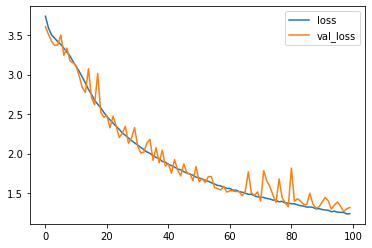

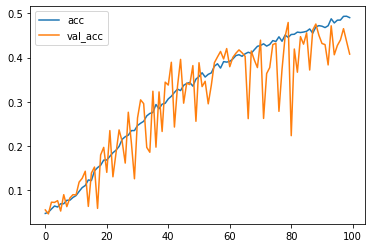

In [149]:
filepath = "./hijacked_weights/hijacked-{epoch:02d}.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)

plot = live_plot()
dump = dump_to_file()

callbacks_list = [checkpoint, plot, dump]     
fit_data = model.fit(X.reshape(n, input_length, 1), Y, validation_split=0.20,epochs=100, batch_size=64, callbacks=callbacks_list)

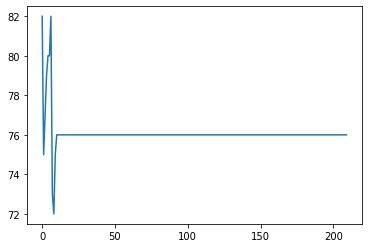

In [152]:
#Generate 200 notes
#model.load_weights('./hijacked_weights/hijacked-125.hdf5')
#random sequence to initialize predictions
init = X[np.random.randint(0,len(X))]

predicted_notes = np.zeros(200 + input_length)
predicted_notes[0:input_length] = init

for note_index in range(200):
    x = predicted_notes[note_index:note_index + input_length]
    prediction = model.predict(x.reshape(1,10,1))
    predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
predicted_notes = predicted_notes * max_note
plt.plot(predicted_notes)

In [151]:
predicted_notes

array([70., 43., 55., 79., 78., 74., 73., 74., 71., 71., 72., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
       73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73

In [7]:
midi_functions.create_midi_from_notes(predicted_notes, on=250)

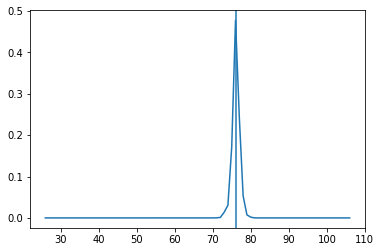

In [159]:
#see what the ouput of softmax looks like
x = X[np.random.randint(0,len(X))]
prediction = model.predict(x.reshape(1,10,1))
plt.plot(sorted_notes, prediction.reshape(n_notes_Y))
plt.axvline(x=x[9] * max_note)

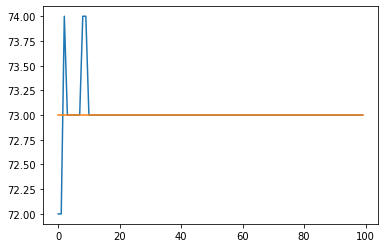

In [160]:
def generate_music_with_bias(bias):
    length = len(bias)
    init = X[np.random.randint(0,len(X))] #Picks out a random training example to begin generation

    predicted_notes = np.zeros(length + input_length)
    predicted_notes[0:input_length] = init
    #predicted_notes[9] = mean / max_note
    
    for note_index, note in enumerate(bias):
        x[0:input_length - 1] = predicted_notes[note_index:note_index + input_length - 1]
        x[input_length - 1] = note / max_note
        prediction = model.predict(x.reshape(1,input_length,1))
        predicted_notes[note_index + input_length] = sorted_notes[np.argmax(prediction)] / max_note
    
    return predicted_notes[input_length:] * max_note
    
bias = np.ones(100) * 73
predicted_notes = generate_music_with_bias(bias)
plt.plot(predicted_notes)
plt.plot(bias)

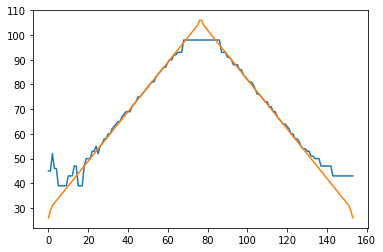

In [161]:
bias = np.concatenate((sorted_notes, sorted_notes[::-1]))
predicted_notes = generate_music_with_bias(bias)
plt.plot(predicted_notes)
plt.plot(bias)

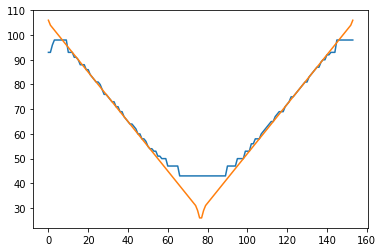

In [162]:
bias = np.concatenate((sorted_notes[::-1], sorted_notes))
predicted_notes = generate_music_with_bias(bias)
plt.plot(predicted_notes)
plt.plot(bias)

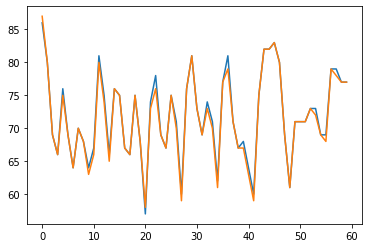

In [163]:
traj = np.loadtxt('data/e_0000.txt')
predicted_notes = generate_music_with_bias(traj)
plt.plot(predicted_notes[:60])
plt.plot(traj[:60])